In [1]:
"""
This script is suposed to produce plots of the results from
macroscopic approximation of the network-based microscopic model of divestment.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class plot_routines(object):
    """
    this contains the routines to make different plots to compare the two
    types of model description
    """

    def __init__(self, base_path):
        with pd.HDFStore(base_path + 'micro/mean.h5') as store:
            self.micro_mean = store.select('dat')
        with pd.HDFStore(base_path + 'micro/std.h5') as store:
            self.micro_sem = store.select('dat')
        with pd.HDFStore(base_path + 'mean/mean.h5') as store:
            self.macro_mean = store.select('dat')
        with pd.HDFStore(base_path + 'mean/std.h5') as store:
            self.macro_sem = store.select('dat')

        self.data_sets = [self.micro_mean, self.micro_sem,
                     self.macro_mean, self.macro_sem]

        for d in self.data_sets:
            d.index = d.index.droplevel(['approximate', 'test', 'sample'])

        self.variable_combos = [['x', 'y', 'z'], ['c', 'g'], ['mu_c^c', 'mu_d^d'],
                                ['mu_c^d', 'mu_d^c']]
        self.latex_labels = [['$x$', '$y$', '$z$'], ['$c$', '$g$'],
                             ['$\mu^{(c)}_c$', '$\mu^{(d)}_d$'],
                             ['$\mu^{(c)}_d$', '$\mu^{(d)}_c$']]

        self.colors = 'rgbk'

    def mk_plots(self, bd):

        # select data for given value of bd
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs(bd, level=0))

        phi_vals = local_datasets[0].index.levels[0].values

        l_phi = len(phi_vals)
        l_vars = len(self.variable_combos)

        fig = plt.figure()
        axes = [fig.add_subplot(l_vars, l_phi, i + 1 + j * l_phi)
                for i in range(l_phi)
                for j in range(l_vars)]

        for i, phi in enumerate(phi_vals):
            for j, variables in enumerate(self.variable_combos):
                ax_id = self.grid_index(i, j, l_phi, l_vars) - 1
                # local data set for specifiv value of phi
                ldp = []
                for d in local_datasets:
                    ldp.append(d.xs(phi, level=0))
                print(self.grid_index(i, j, l_phi, l_vars))
                ldp[0][variables]\
                    .plot(
                    ax=axes[ax_id],
                    legend=False,
                    color=self.colors)
                for k, variable in enumerate(variables):
                    upper_limit = np.transpose(ldp[0][[variable]].values \
                                  + ldp[1][[variable]].values)[0]
                    lower_limit = np.transpose(ldp[0][[variable]].values \
                                  - ldp[1][[variable]].values)[0]
                    axes[ax_id].fill_between(ldp[0].index.values,
                                     upper_limit, lower_limit,
                                     color=self.colors[k],
                                     alpha=0.2)
                    ldp[2][variables] \
                        .plot(
                        ax=axes[ax_id],
                        legend=False,
                        color=self.colors,
                        style='-.')

        return fig

    def mk_switchplots(self, bd, phi):
                # select data for given value of bd and phi
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs([bd, phi], level=[0, 1]))
        switchlist = np.load('switch_bd={}_phi={}.pkl'.format(bd, phi))

        fig = plt.figure()

        vars = self.variable_combos[2] + self.variable_combos[3]
        for v, var in enumerate(vars):
            direction = 1 if var[-2] == 'c' else 0
            capital_kind = '$K^{(c)}$' if var[-1] == 'c' else '$K^{(d)}$'
            print( var, capital_kind, direction)
            c1 = 'b'
            ax1 = fig.add_subplot(2, 2, v + 1)
            mu = local_datasets[0][[var]]
            emu = local_datasets[1][[var]]
            upper = np.transpose(np.array(mu.values + 2*emu.values))[0]
            lower = np.transpose(np.array(mu.values - 2*emu.values))[0]
            mu.plot(ax=ax1)
            ax1.plot(emu.index.values, upper, color=c1, alpha=0.4)
            ax1.plot(emu.index.values, lower, color=c1, alpha=0.4)
            plt.fill_between(emu.index.values,
                             upper,
                             lower,
                             color='k', alpha=0.2)
            l = len(switchlist[['direction']].values)
            ldots = 1000
            ts = []
            ks = []
            for i in range(ldots):
                k = np.random.randint(l)
                t = 1 if switchlist[['direction']].values[k] == direction else 0
                if t:
                    ts.append(switchlist.index.values[k])
                    ks.append(switchlist[[capital_kind]].values[k])
            ax1.plot(ts, ks, 'o'+c1, alpha=0.2, label=capital_kind)
            handles, labels = ax1.get_legend_handles_labels()
            ax1.legend(handles, ['$\mu_{}^{{({})}}$'.format(var[-2], var[-1]), capital_kind], loc=0)
        return fig



    def mk_4plots(self, bd, phi, eps):
        # set opacity for plots of micro data:
        micro_alpha=0.8
        # select data for given value of bd and phi
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs([bd, phi, eps], level=[0, 1, 2]))

        l_vars = len(self.variable_combos)
        fig = plt.figure(figsize=(8,6))
        axes = [fig.add_subplot(2, 2, i + 1) for i in range(l_vars)]

        legend_locations = [4, 7, 1, 7]
        upper_limits = [1., 80, 11, 10, 15]
        lower_limits = [-.8, 0., 0., 0., 0.]

        for j, variables in enumerate(self.variable_combos):
            ax_id = j
            axes[ax_id].set_xlim([0,1000])
            # local data set for specify value of phi
            ldp = local_datasets
            if j == 1:
                print( 'c exception')
                c_ax = axes[ax_id].twinx()
                ldp[0][variables[0]] \
                    .plot(
                    ax=axes[ax_id],
                    color=self.colors[0],
                    alpha=micro_alpha)
                ldp[0][variables[1]] \
                    .plot(
                    ax=c_ax,
                    color=self.colors[1],
                    alpha=micro_alpha)

                c_ax.set_ylim([0, 5])
            else:
                ldp[0][variables] \
                    .plot(
                    ax=axes[ax_id],
                    color=self.colors,
                    alpha=micro_alpha)
            for k, variable in enumerate(variables):
                ax = axes[ax_id]
                if variable == 'g':
                    ax = c_ax
                    ax.set_ylim([lower_limits[-1], upper_limits[-1]])

                upper_limit = np.transpose(ldp[0][[variable]].values \
                                           + ldp[1][[variable]].values)[0]
                lower_limit = np.transpose(ldp[0][[variable]].values \
                                           - ldp[1][[variable]].values)[0]
                ax.fill_between(ldp[0].index.values,
                                         upper_limit, lower_limit,
                                         color='k',
                                         alpha=0.05)
                ax.plot(ldp[0].index.values,
                                         upper_limit,
                                         color=self.colors[k],
                                         alpha=0.2)
                ax.plot(ldp[0].index.values,
                                         lower_limit,
                                         color=self.colors[k],
                                         alpha=0.2)
                
                ldp[2][[variable]] \
                    .plot(ax=ax,
                          color=self.colors[k],
                          legend=False,
                          style='--',
                          linewidth=2
                          )

            ax = axes[ax_id]
            ax.set_ylim([lower_limits[j], upper_limits[j]])
            k = len(variables)
            patches, labels = ax.get_legend_handles_labels()
            labels = self.latex_labels[j]
            if j == 1:
                gArtist = plt.Line2D((0,1),(0,0), color=self.colors[1])
                cArtist = plt.Line2D((0,1),(0,0), color=self.colors[0])
                patches = [cArtist, gArtist]
            if j is 0:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            lg = ax.legend(patches[:k], labels[:k],
                           loc=legend_locations[ax_id],
                           title='',
                           fontsize=12)
            lg.get_frame().set_alpha(0.8)

            #ax.set_title('')
            #ax.set_loc

        return fig


    def grid_index(self, row, col, n_rows, n_cols):
        """
        calculate index number in subplot grids
        grid_index(0,0) = 1 ~ upper left corner
        to index the axis list, one might use grid_index - 1
        """
        return col + 1 + row * n_cols

c exception
c exception
c exception
c exception
c exception
c exception
c exception
c exception
c exception
c exception


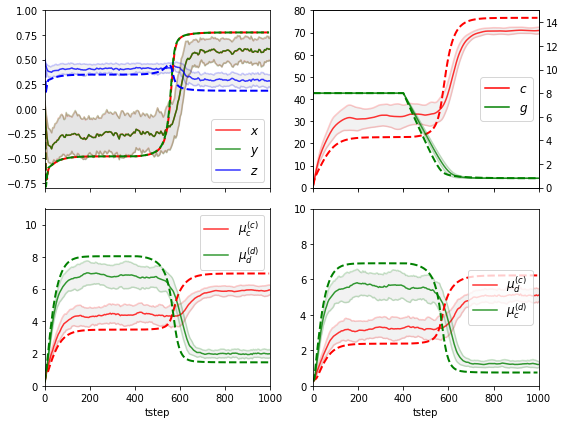

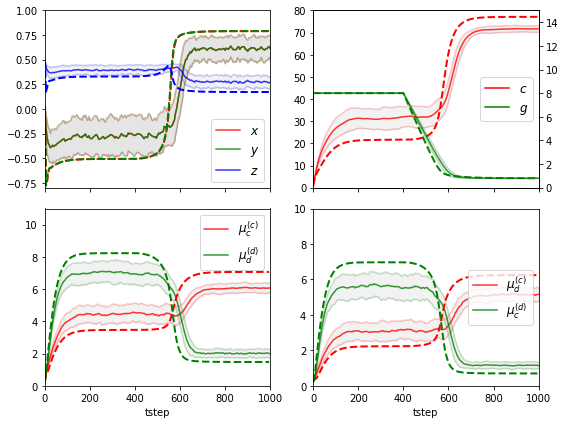

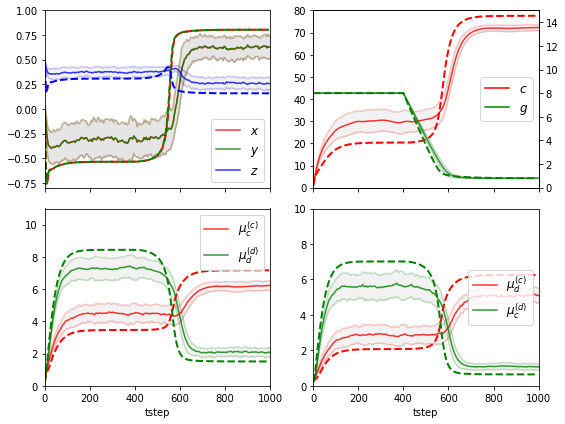

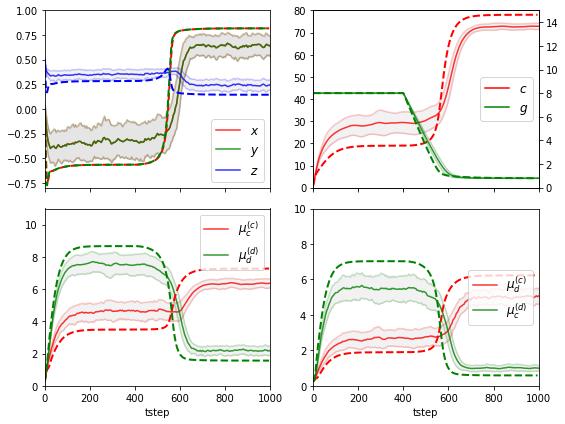

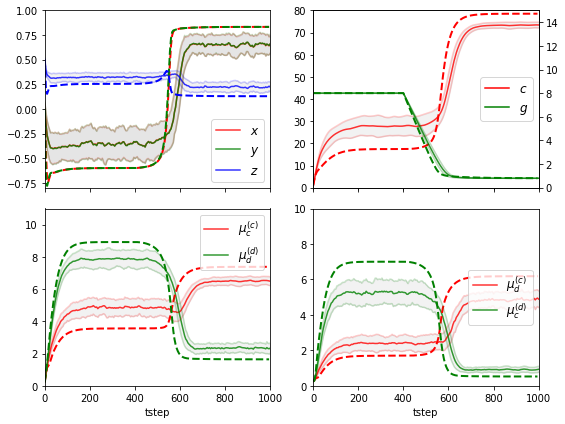

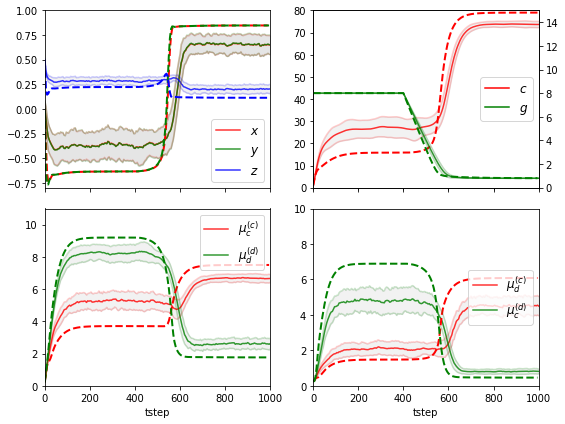

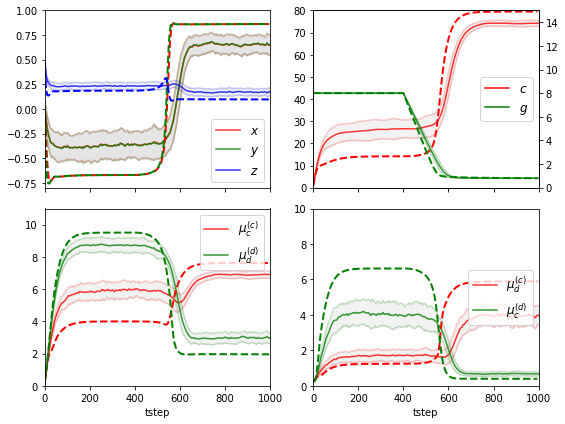

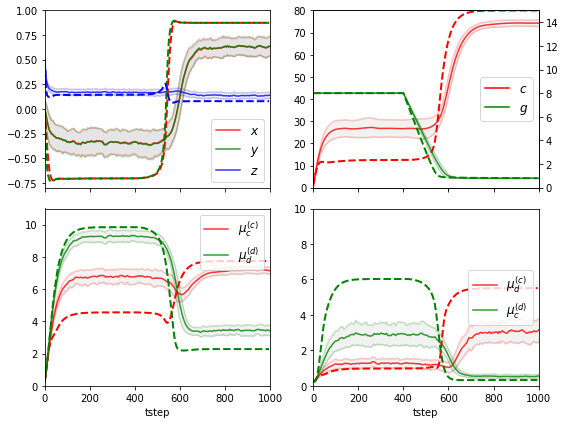

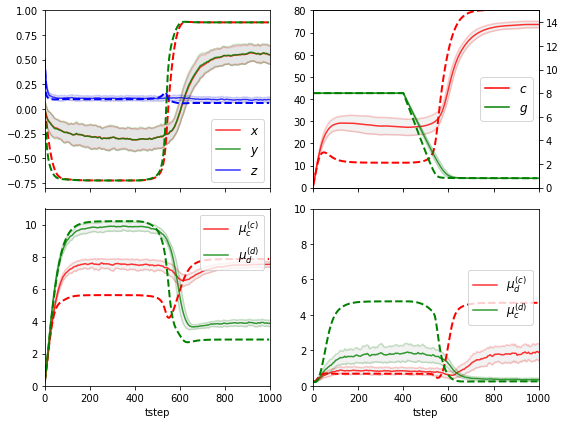

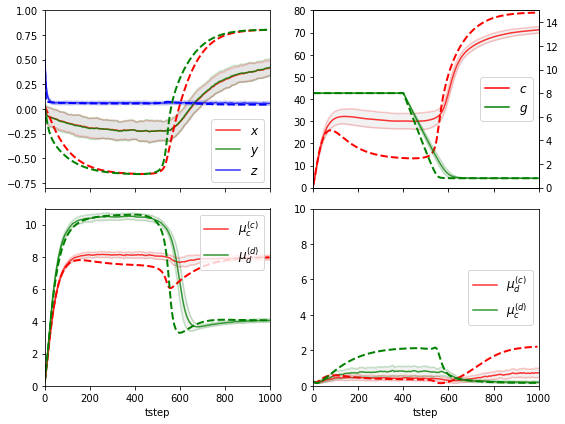

In [4]:
import time

bc, eps = 1.25, 0.05

#prt = plot_routines(base_path='/home/jakob/Project_Divestment/PyDivestment/output_data/test_output/P2/')
prt = plot_routines(base_path='/home/jakob/Project_Divestment/PyDivestment/output_data/P2/')


for phi in [round(x, 5) for x in list(np.linspace(0.0, 0.9, 10))]:
#for phi in [.1, .4, .8, 1.]:

    figure = prt.mk_4plots(bc, phi, eps)
    figure.tight_layout()
    figure.savefig('trajectory_bc={}_phi={}.pdf'.format(bc, phi))


In [5]:
prt.macro_mean.head()

W_c       W_d          c    g       i_c       k_c  \
b_d phi eps tstep                                                           
1.0 0.0 0.1 0.0    0.224684  0.224684   1.000000  8.0  0.501667  0.500000   
            5.0    0.328812  0.321309   4.009884  8.0  0.534570  0.981175   
            10.0   0.413800  0.402246   7.655507  8.0  0.600292  1.645871   
            15.0   0.486429  0.473614  11.739808  8.0  0.612628  2.403801   
            20.0   0.550172  0.536412  15.965910  8.0  0.609043  3.152280   

                        k_d       l_c       l_d       n_c  ...      mu_d^d  \
b_d phi eps tstep                                          ...               
1.0 0.0 0.1 0.0    0.500000  0.548197  0.451803  0.501667  ...    0.250000   
            5.0    0.963151  0.596281  0.403719  0.528831  ...    0.610887   
            10.0   1.401480  0.637517  0.362483  0.593477  ...    0.898262   
            15.0   1.808020  0.668453  0.331547  0.606273  ...    1.145652   
            20.0   2.224907  0.684397  0.315603  0.602996  ...    1.388134   

                          x         y         z    C    G  K_c^c  K_c^d  \
b_d phi eps tstep                                                         
1.0 0.0 0.1 0.0    0.003333 -0.000459  0.493197  0.0  0.0    0.0    0.0   
            5.0    0.057662  0.106527  0.450941  0.0  0.0    0.0    0.0   
            10.0   0.186955  0.210952  0.436509  0.0  0.0    0.0    0.0   
            15.0   0.212546  0.213229  0.436168  0.0  0.0    0.0    0.0   
            20.0   0.205991  0.203225  0.438007  0.0  0.0    0.0    0.0   

                   K_d^c  K_d^d  
b_d phi eps tstep                
1.0 0.0 0.1 0.0      0.0    0.0  
            5.0      0.0    0.0  
            10.0     0.0    0.0  
            15.0     0.0    0.0  
            20.0     0.0    0.0  

[5 rows x 28 columns]

In [6]:
prt.micro_mean.head()

W_c       W_d          c    g       i_c       k_c  \
b_d phi eps tstep                                                           
1.0 0.0 0.1 0.0    0.224685  0.224686   1.000051  8.0  0.501700  0.500010   
            5.0    0.328868  0.321000   4.010489  8.0  0.513466  0.980434   
            10.0   0.417460  0.403819   7.546115  8.0  0.513809  1.555760   
            15.0   0.492005  0.476224  11.267773  8.0  0.532665  2.180832   
            20.0   0.555750  0.539084  15.007792  8.0  0.538303  2.827119   

                        k_d       l_c       l_d       n_c     ...      \
b_d phi eps tstep                                             ...       
1.0 0.0 0.1 0.0    0.500010  0.548199  0.451801  0.501700     ...       
            5.0    0.968834  0.594959  0.405041  0.510760     ...       
            10.0   1.502181  0.610347  0.389653  0.510135     ...       
            15.0   2.046057  0.620558  0.379442  0.529080     ...       
            20.0   2.566125  0.629651  0.370349  0.534975     ...       

                     mu_d^d         x         y         z            C  \
b_d phi eps tstep                                                        
1.0 0.0 0.1 0.0    0.250010  0.003400  0.004368  0.501313   100.005109   
            5.0    0.611298  0.021520  0.021333  0.456647   401.048861   
            10.0   0.926098  0.020271  0.020547  0.450080   754.611515   
            15.0   1.244790  0.058161  0.056515  0.446357  1126.777321   
            20.0   1.541990  0.069950  0.069045  0.445362  1500.779232   

                            G         Kcc         Kcd         Kdc         Kdd  
b_d phi eps tstep                                                              
1.0 0.0 0.1 0.0    799.999952   25.085969   24.914851   25.084849   24.915962  
            5.0    799.999952   62.687955   35.070284   36.671534   59.937724  
            10.0   799.999952   97.214158   57.858933   58.511461   91.196843  
            15.0   799.999952  137.365038   80.004283   85.887512  118.098142  
            20.0   799.999952  176.826956  104.975910  111.169530  144.710771  

[5 rows x 28 columns]

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

selector = 'approximate = 1 & sample = 0 & eps = 0.05 & b_d = 1.25 & phi = .4'
path = '/home/jakob/Project_Divestment/PyDivestment/output_data/test_output/P2/micro/'
data = []
measures = ['mean', 'std']

for m in measures:
    with pd.HDFStore(path + f'{m}.h5') as store:
        data.append(store.select('dat', selector))
for d in data:
    d.index = d.index.droplevel('eps').droplevel('b_d').droplevel('test').droplevel('sample').droplevel('approximate').droplevel('phi')
    d.columns = [f'${var}$' for var in d.columns]
    
def plotfunc(variables, colors, data, ax):
    lns = []
    for i, var in enumerate(variables):
        
        ln = ax.plot(data[0].index.values, data[0][var].values, color=colors[i], label=var)[0]
        lns.append(ln)
        upper_limit = np.transpose(data[0][[var]].values \
                                   + data[1][[var]].values)[0]
        lower_limit = np.transpose(data[0][[var]].values \
                                   - data[1][[var]].values)[0]
        ax.fill_between(data[0].index.values,
                                 upper_limit, lower_limit,
                                 color='k',
                                 alpha=0.05)
        ax.plot(data[0].index.values,
                                 upper_limit,
                                 color=colors[i],
                                 alpha=0.2)
        ax.plot(data[0].index.values,
                                 lower_limit,
                                 color=colors[i],
                                 alpha=0.2)
        ax.set_xlim([400, 750])
    print(lns)
    return lns

[<matplotlib.lines.Line2D object at 0x7f890ff437b8>, <matplotlib.lines.Line2D object at 0x7f890ff60780>]
[<matplotlib.lines.Line2D object at 0x7f890ff3b400>, <matplotlib.lines.Line2D object at 0x7f890fec5358>]


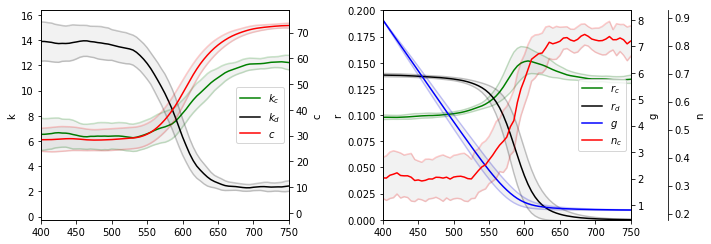

In [8]:
colors = ['g', 'k']
variables = ['$k_c$', '$k_d$']

fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(121)

lns1 = plotfunc(variables, colors, data, ax)

axb = ax.twinx()

lns2 = plotfunc(['$c$'], ['r'], data, axb)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')

ax2 = fig.add_subplot(122)

lns3 = plotfunc(variables=['$r_c$', '$r_d$'], 
                colors=['g', 'k'], data=data, ax=ax2)
ax2.set_ylim([0., 0.2])

ax2b = ax2.twinx()

lns4 = plotfunc(variables=['$g$'],
                colors=['b'], data=data, ax=ax2b)

ax2c = ax2.twinx()
ax2c.spines["right"].set_position(("axes", 1.15))

lns5 = plotfunc(variables=['$n_c$'],
                colors=['r'], data=data, ax=ax2c)

lns = lns3+lns4+lns5
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='center right')

ax.set_ylabel('k')
axb.set_ylabel('c')
ax2.set_ylabel('r')
ax2b.set_ylabel('g')
ax2c.set_ylabel('n')


plt.tight_layout()
fig.savefig('example_trajectory.pdf')